In [392]:
""" Load Relevant Packages """ 

import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning')

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
from typing import Union
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import numpy.ma as ma
import math


import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dateutil.relativedelta import relativedelta


In [165]:
"""
Download data created in Pyhton
"""

# create a numpy array
nparray = df_mean_var_port_weights_monthly

# Saving the array
np.savetxt("df_mean_var_port_weights_monthly.csv", nparray, delimiter=",")

# Reading the csv into an array
firstarray = np.genfromtxt("df_mean_var_port_weights_monthly.csv", delimiter=",")

In [759]:
"""
Load Data
"""
ret = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data themes.xlsx')
returns = ret.set_index('date')

# calculate start and end dates from index
start_date = returns.index.min()
end_date = returns.index.max()

returns

,Accruals,Debt Issuance,Investment,Low Leverage,Low Risk,Momentum,Profit Growth,Profitability,Quality,Seasonality,Short Term Reversal,Size,Value,Mkt-RF
date,,,,,,,,,,,,,,
1964-01-02,0.002218,0.001700,0.002860,0.002490,-0.007273,0.000212,-0.000124,-0.003932,-0.001653,0.001605,0.000123,0.006472,0.003631,0.0060
1964-01-03,0.002041,0.001234,0.002658,0.001435,-0.000628,-0.001098,0.000238,-0.000239,0.000392,-0.000176,0.001710,-0.000972,0.000583,0.0017
1964-01-06,0.002413,0.000674,0.001516,0.001132,0.000137,0.000451,0.001266,0.000672,0.000032,-0.000035,-0.001097,-0.000414,0.000060,0.0023
1964-01-07,0.001250,0.000588,0.003444,-0.002608,0.002488,-0.000712,0.000752,-0.001695,-0.003224,-0.000067,0.000025,0.000551,0.003340,0.0004
1964-01-08,0.000871,0.000293,0.000247,0.000991,-0.001216,0.000956,-0.000016,0.000189,0.000475,0.000418,0.001291,0.001412,0.000015,0.0034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.000987,0.000392,0.002706,-0.008439,0.004226,0.004522,0.005605,0.010034,0.003376,0.002389,0.001764,-0.006097,0.010538,0.0051
2022-12-27,-0.002134,-0.000310,0.007206,-0.012162,0.012761,0.008263,0.004090,0.013029,0.004203,0.001239,-0.000879,-0.011056,0.012541,-0.0051
2022-12-28,0.002113,-0.000499,0.000868,0.003135,0.002512,-0.000651,-0.004126,-0.005820,-0.004381,-0.002041,0.001889,0.004943,-0.005735,-0.0123


In [760]:
# colors for factors

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Define inputs for calculations

In [761]:
"""
Define inputs
"""

# number of periods
num_periods = len(ret)

# number of factors
num_assets = len(returns.columns)

# window size 
window_size = 252 # 1 year of daily observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = window_size/2

# time points
time_points = np.arange(1, window_size + 1)

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
weights_eq = np.array(w_eq).astype(float)


# Estimate Covariance Matrix

In [762]:
"""
Simple Covariance Matrix
"""

def calculate_simple_cov_mat(x: np.ndarray, axis: int = 0) -> np.ndarray:
    
    x = x.T if axis == 1 else x
    
    cov_mat = np.cov(x, rowvar=False)
    
    return cov_mat

In [763]:
"""
Exponential Decaying Covariance Matrix
"""

# exponential probabilities for decaying covariance matrix
def calculate_exponential_decay_probabilities(target_time_point: Union[int, float], time_points: np.ndarray,
                                              half_life: Union[float, int]) -> np.ndarray:
    """
    Calculates exponential decay probabilities for an array of time points based on a target time point and a half life.
    Parameters
    ----------
    target_time_point:
        The target time point.
    time points:
        The array of time points to calculate probabilities for.
    half_life:
        The half life of the exponential decay.
    Returns
    -------
    Exponential decay probabilities.
    """
    
    numerator = np.exp(-np.log(2) / half_life * np.clip(target_time_point - time_points, 0, np.inf))
    denominator = np.sum(numerator)

    p_t = numerator / denominator

    return p_t

exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# Define function for decaying covariance matrix
def calculate_decaying_cov_mat(x: np.ndarray, probs: np.ndarray, axis: int = 0) -> np.ndarray:

    """
    Estimates a covariance matrix based on a historical dataset and a set of probabilities.
    Parameters
    ----------
    x:
        The dataset to estimate covariance for.
    probs:
        The probabilities to weight the observations of the dataset by.
    axis:
        The axis to estimate over.
    Returns
    -------
    np.ndarray
        The estimated covariance matrix.
    """

    x = x.T if axis == 1 else x

    expected_x_squared = np.sum(probs[:, None, None] * np.einsum('ji, jk -> jik', x, x), axis=0)
    mu = probs @ x
    mu_squared = np.einsum('j, i -> ji', mu, mu)
    cov_mat = expected_x_squared - mu_squared

    return cov_mat

In [764]:
"""
Ledoit and Wold Covariance Shrinkage
"""

def ledoit_wolf_constant_variance(data: np.ndarray, demean: bool = True) -> np.ndarray:
    """
    Computes the Ledoit and Wolf (2004) shrinkage covariance matrix
    See https://www.sciencedirect.com/science/article/pii/S0047259X03000964
    Parameters
    ----------
    data:
        Num. observations x Num. variables
    demean:
        Boolean indicating whether to demean data.
    Returns
    -------
    np.ndarray
        Covariance matrix
    """

    if demean:
        data = data - np.mean(data, axis=0)[None, :]

    T = data.shape[0]

    # calculate sample covariance matrix
    S = data.T @ data / T  # np.cov(data, rowvar=False)

    # get dimension
    N = S.shape[0]

    # calculate constant variance
    m = np.trace(S) / N

    # shrinkage target
    shrink_target = m * np.eye(N)

    # delta
    d2 = np.linalg.norm(S - shrink_target, ord='fro') ** 2 / N

    # beta
    b2_bar = np.sum([np.linalg.norm(np.outer(data[t, :], data[t, :]) - S, ord='fro') ** 2 / N
                     for t in range(T)]) / (T ** 2)

    b2 = np.min([d2, b2_bar])

    # alpha
    a2 = d2 - b2

    # calculate new covariance matrix
    shrinkage_cov_mat = (b2 / d2) * shrink_target + (a2 / d2) * S

    return shrinkage_cov_mat

In [765]:
"""
Simple EPO 
"""

def shrunk_cov_mat(returns: np.ndarray, shrinkage_param: float = 0.5) -> np.ndarray:
    returns_df = pd.DataFrame(returns)
    corr_matrix = returns_df.corr()
    vol_vec = np.sqrt(np.diag(returns_df.cov()))
    shrinked_corr = corr_matrix * (1 - shrinkage_param) + np.identity(len(corr_matrix)) * shrinkage_param
    return np.outer(vol_vec, vol_vec) * shrinked_corr

# Calculate Risk Contributions for Equally Weighted Portfolio

In [785]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
    """
    Function that calculates marginal risk using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    inner_derivative = cov_mat @ weights

    return inner_derivative / total_risk


def calculate_risk_contributions_std(weights: np.ndarray, cov_mat: np.ndarray, scale: bool = False) -> np.ndarray:
    """
    Function that calculates risk contributions using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    scale:
        Scale risk contribution.
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_std(weights, cov_mat)
    mrc = weights * mr

    if scale:
        mrc /= np.sum(mrc)

    return mrc

In [767]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_simple_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

In [770]:
"""
Perform calculations
"""

rel_risk_contribs_eq = np.zeros((eff_num_periods, num_assets))

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # calculate relative risk constribution 
    rel_risk_contribs_eq[t, :] = calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

(0.0, 1.0)

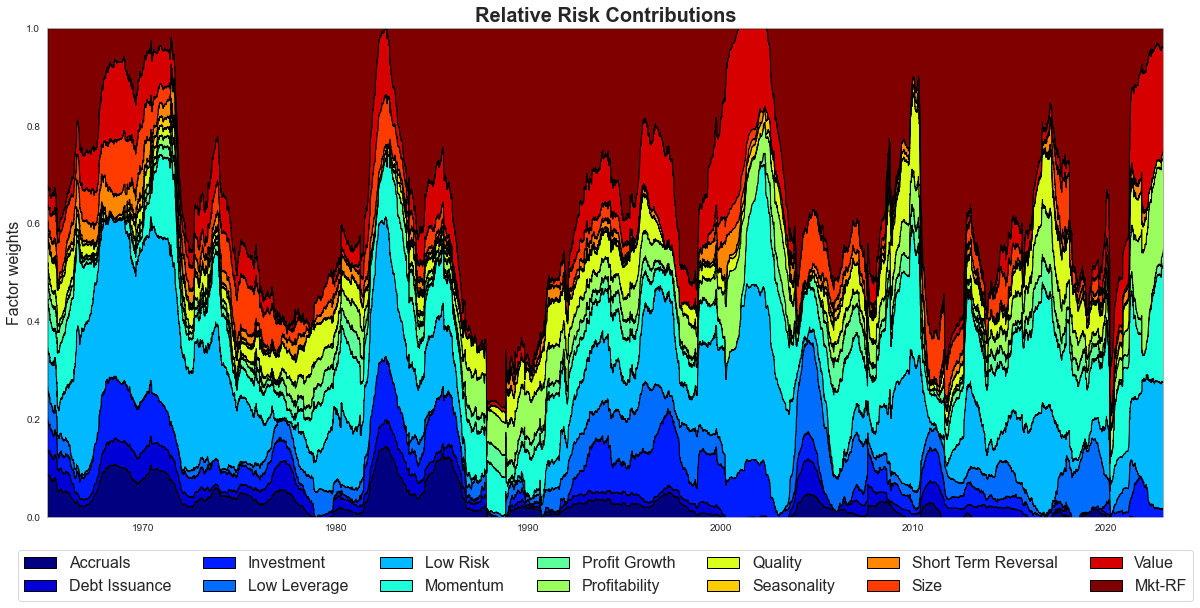

In [771]:
"""
Plot Risk contributions
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              rel_risk_contribs_eq.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_title("Relative Risk Contributions", fontsize=20, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.set_ylabel('Factor weights', fontsize=16)
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Calculate Diversification Ratio

In [773]:
"""
Define function for portfolio std and var
"""

def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights


def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))


def cov_to_corr_matrix(cov_mat):
    
    vols = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1 # numerical error 
    
    return corr_mat

In [774]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""

def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = calculate_portfolio_std(weights=weights, cov_mat=cov_mat)
    
    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [775]:
"""
Equally Weighted Portfolio - CC Ratios and Correlation
"""

cc_ratios_epo = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations for shrunk cov_mat
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # convert to correlation matrix
    corr_mat = cov_to_corr_matrix(cov_mat).values
    
    # average correlation
    avg_corr[t] = corr_mat[upper_tri_idx].flatten().mean()
    
    # calculate cc ratio 
    cc_ratios_epo[t] = calculate_cc_ratio(w_eq, cov_mat)


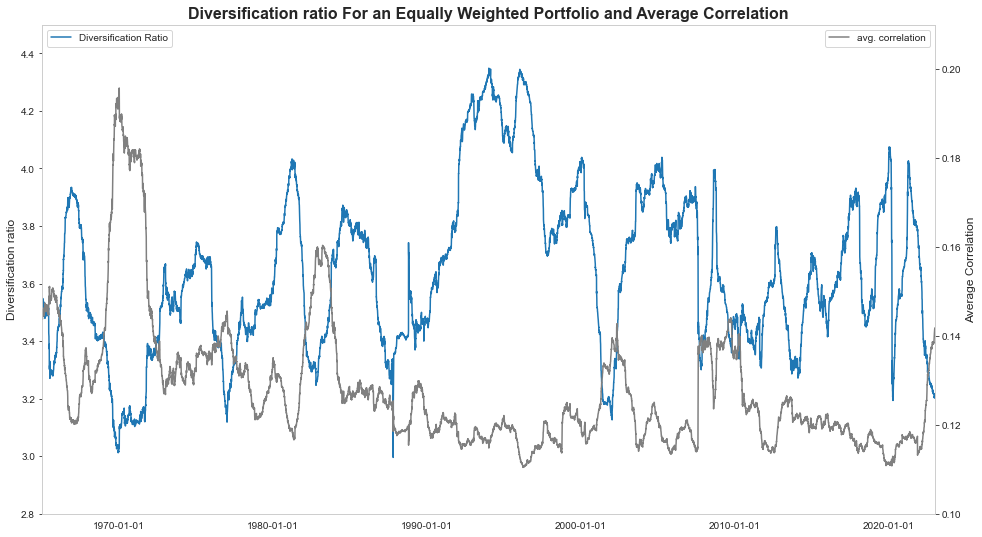

In [780]:
"""
Plot Diversification Ratio and Average Correlation
"""

fig, ax = plt.subplots(figsize=(16, 9))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.plot(returns.index[window_size:], cc_ratios_epo, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio", fontsize=12)
ax.set_title("Diversification ratio For an Equally Weighted Portfolio and Average Correlation", fontsize=16, fontweight='bold');
ax.legend(loc='upper left')
ax_new = ax.twinx()
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.set_ylim(2.8,4.5)
ax_new.set_ylim(0.1,0.21)
ax_new.set_ylabel("Average Correlation", fontsize=12)
ax_new.plot(returns.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')

# Remove gridlines
ax.grid(False)
ax_new.grid(False)


# Most Diversified Portfolio

In [787]:
"""
Define function for long only portfolio
"""

def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [788]:
"""
Perform calculations for MDP with monthly rebalancing 
"""

most_div_port_weights_monthly_epo = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_monthly_epo = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo[t, :] = most_div_port_weights_monthly_epo[t-1, :]
        most_div_port_cc_monthly_epo[t] = most_div_port_cc_monthly_epo[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo = pd.DataFrame(data=most_div_port_weights_monthly_epo,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


(0.0, 1.0)

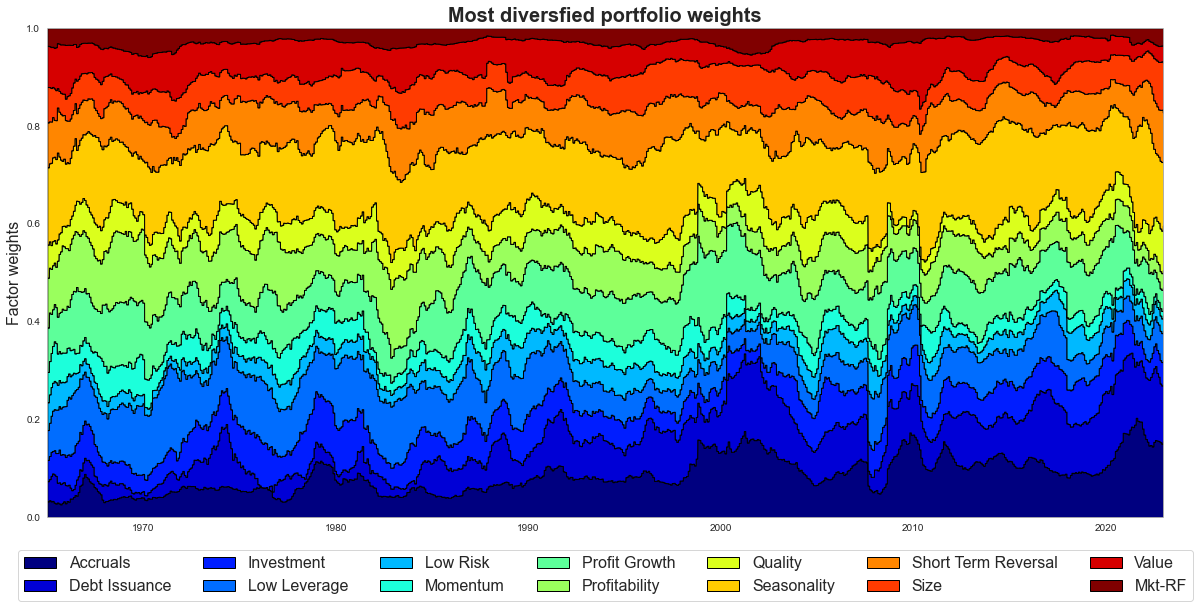

In [789]:
"""
Plot MDP Weights Monthly Rebalancing
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              most_div_port_weights_monthly_epo.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=16)
ax.set_title("Most diversfied portfolio weights",fontsize=20, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Minimum Variance Portfolio

In [795]:
""" 
Define function for minimum variance portfolio 
"""

def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [796]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing
"""

min_var_port_weights_monthly_epo = np.zeros((eff_num_periods, num_assets))
min_var_port_cc_monthly_epo = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # minimum variance portfolio
        min_var_port_weights_monthly_epo[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly_epo[t] = calculate_cc_ratio(min_var_port_weights_monthly_epo[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly_epo[t, :] = min_var_port_weights_monthly_epo[t-1, :]
        min_var_port_cc_monthly_epo[t] = min_var_port_cc_monthly_epo[t-1]

# store in data-frame
df_min_var_port_weights_monthly_epo = pd.DataFrame(data=min_var_port_weights_monthly_epo,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


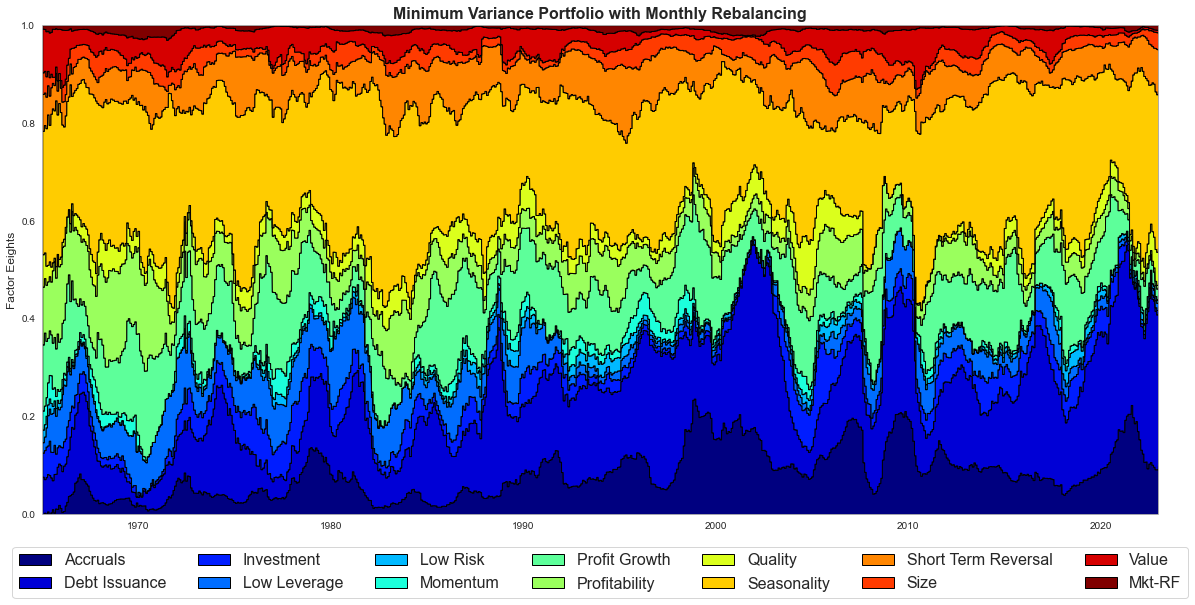

In [797]:
""" 
Plot Minimum Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_monthly_epo.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Eeights', fontsize=12)
ax.set_title("Minimum Variance Portfolio with Monthly Rebalancing", fontsize=16, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');

# Mean-Variance Portfolio (Max Sharpe Ratio)

In [798]:
"""
Define Function for Tangency Portfolio - Mean-Variance Portfolio
"""

def tangency_portfolio(cov_mat: np.ndarray, returns: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights subject to no shorting.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    returns: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights subject to no shorting.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    mu = np.mean(returns, axis=0)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)

    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # define no shorting constraint
    bounds = [(0, None) for i in range(num_assets)]
    
    # define sharpe ratio
    def neg_sharpe_ratio(weights, excess_mu, cov_mat_inv):
        p_return = np.dot(excess_mu, weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
        return -(p_return / p_volatility)

    result = optimize.minimize(neg_sharpe_ratio, np.repeat(1.0 / num_assets, num_assets), 
                               args=(excess_mu, cov_mat_inv), method='SLSQP', bounds=bounds, constraints=eq_constraint)
    
    w_max_sr = result.x
    
    return w_max_sr

In [799]:
""" 
Define function for minimum variance portfolio 
"""

def sharpe_ratio(weights, returns):
    """
    Calculate the Sharpe Ratio for a given portfolio.

    :param returns: A 2D numpy array where each row represents an asset and each column represents a historical return.
    :param weights: A 1D numpy array representing the weights of each asset in the portfolio.
    """
    # Calculate the weighted returns of the portfolio
    weighted_returns = np.dot(returns, weights)
    
    # Calculate the mean and standard deviation of the weighted returns
    mean_returns = np.mean(weighted_returns)
    std_returns = np.std(weighted_returns)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = (mean_returns) / std_returns

    return sharpe_ratio

def tangency_portfolio2(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -sharpe_ratio(x, returns)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [800]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing
"""

mean_var_port_weights_monthly = np.zeros((eff_num_periods, num_assets))
mean_var_port_cc_monthly = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly[t, :] = tangency_portfolio(cov_mat, returns, 0)
        mean_var_port_cc_monthly[t] = calculate_cc_ratio(mean_var_port_weights_monthly[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly[t, :] = mean_var_port_weights_monthly[t-1, :]
        mean_var_port_cc_monthly[t] = mean_var_port_cc_monthly[t-1]

# store in data-frame
df_mean_var_port_weights_monthly = pd.DataFrame(data=mean_var_port_weights_monthly,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


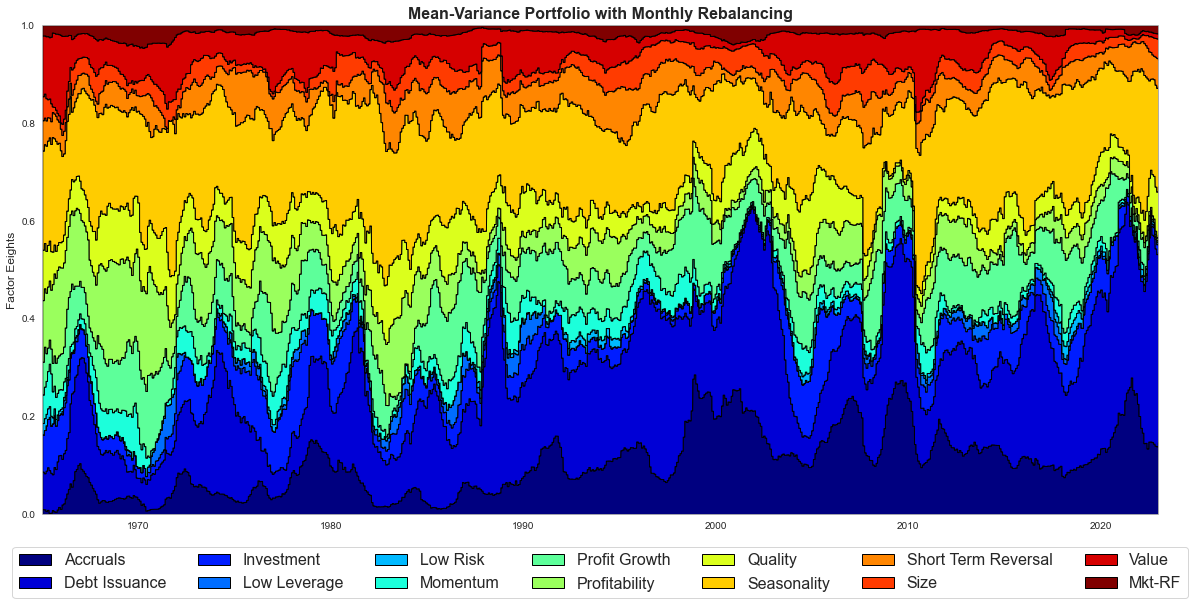

In [801]:
""" 
Plot Mean-Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              mean_var_port_weights_monthly.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Eeights', fontsize=12)
ax.set_title("Mean-Variance Portfolio with Monthly Rebalancing", fontsize=16, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');

# Determining The Right Covariance Estimation Going Forward

In [528]:
"""
Select the portfolio weights for the given covariance estamation below and continue the analysis
"""

# Simple Covariance Matrix:

"""cc_ratios_simple_cov

most_div_port_weights_monthly_simple_cov
most_div_port_cc_monthly_simple_cov

min_var_port_weights_monthly_simple_cov
min_var_port_cc_monthly_simple_cov
"""

# Exponential Decaying Covariance Matrix:

"""cc_ratios_decaying

most_div_port_weights_monthly_decaying
most_div_port_cc_monthly_decaying

min_var_port_weights_monthly_decaying
min_var_port_cc_monthly_decaying
"""

# Ledoit and Wolf 

"""cc_ratios_lw

most_div_port_weights_monthly_lw
most_div_port_cc_monthly_lw

min_var_port_weights_monthly_lw
min_var_port_cc_monthly_lw
"""

# Enhanced Portfolio Optimization

"""cc_ratios_epo

most_div_port_weights_monthly_epo
most_div_port_cc_monthly_epo

min_var_port_weights_monthly_epo
min_var_port_cc_monthly_epo
"""

'\nSelect the portfolio weights for the given covariance estamation below and continue the analysis\n'

# Diversifaction Ratio For All Portfolios

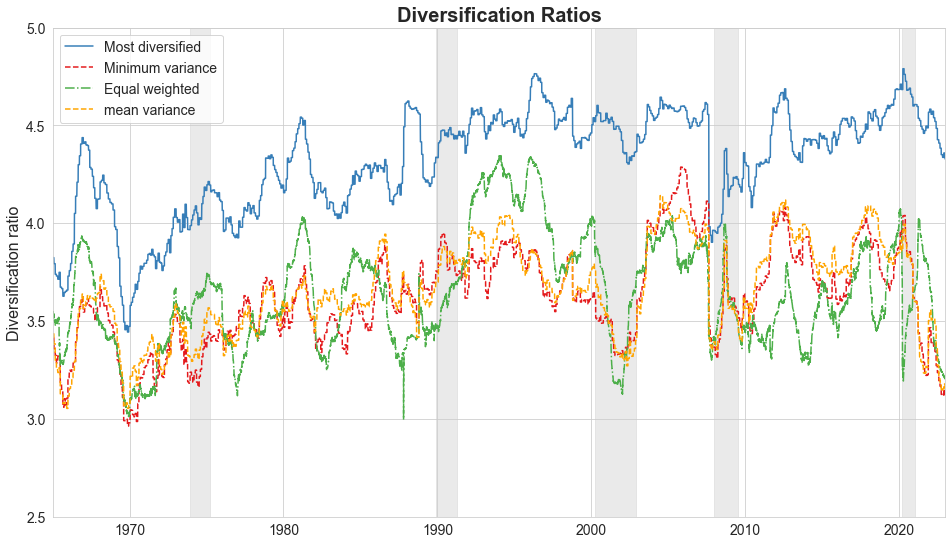

In [805]:
"""
Plot the Diversification Ratios
"""

# Define colors
most_div_color = "#377eb8"
min_var_color = "#e41a1c"
cc_color = "#4daf4a"
gray_color = "#cccccc"

# Define line styles
most_div_linestyle = "-"
min_var_linestyle = "--"
cc_linestyle = "-."

# Plotting Diversification Ratios
fig, ax = plt.subplots(figsize=(16, 9))

# Plot diversification ratios
ax.plot(returns.index[window_size:], most_div_port_cc_monthly_epo, label="Most diversified", color=most_div_color, linestyle=most_div_linestyle)
ax.plot(returns.index[window_size:], min_var_port_cc_monthly_epo, label="Minimum variance", color=min_var_color, linestyle=min_var_linestyle)
ax.plot(returns.index[window_size:], cc_ratios_epo, label="Equal weighted", color=cc_color, linestyle=cc_linestyle)
ax.plot(returns.index[window_size:], mean_var_port_cc_monthly, label="mean variance", color='orange', linestyle=min_var_linestyle)


# Set y-axis label and title
ax.set_ylabel("Diversification ratio", fontsize=16)
ax.set_title("Diversification Ratios", fontweight="bold", fontsize=20)

# Set y-axis limits
ax.set_ylim(2.5, 5)

# Add legend
ax.legend(fontsize=14)

# Fill empty spaces
ax.set_xlim(returns.index[window_size], returns.index[-1])

# Define recession periods
tech_bubble_start = pd.to_datetime("2000-03-31").strftime('%Y-%m-%d')
tech_bubble_end = pd.to_datetime("2002-11-30").strftime('%Y-%m-%d')
financial_crisis_start = pd.to_datetime("2007-12-31").strftime('%Y-%m-%d')
financial_crisis_end = pd.to_datetime("2009-06-30").strftime('%Y-%m-%d')
covid_start = pd.to_datetime("2020-02-29").strftime('%Y-%m-%d')
covid_end = pd.to_datetime("2020-12-31").strftime('%Y-%m-%d')
oil_crisis_start = pd.to_datetime("1973-11-30").strftime('%Y-%m-%d')
oil_crisis_end = pd.to_datetime("1975-03-31").strftime('%Y-%m-%d')
savings_loan_crisis_start = pd.to_datetime("1989-11-30").strftime('%Y-%m-%d')
savings_loan_crisis_end = pd.to_datetime("1991-03-31").strftime('%Y-%m-%d')

# Add vertical shaded regions for recession periods
ax.axvspan(tech_bubble_start, tech_bubble_end, alpha=0.4, color=gray_color)
ax.axvspan(financial_crisis_start, financial_crisis_end, alpha=0.4, color=gray_color)
ax.axvspan(covid_start, covid_end, alpha=0.4, color=gray_color)
ax.axvspan(oil_crisis_start, oil_crisis_end, alpha=0.4, color=gray_color)
ax.axvspan(savings_loan_crisis_start, savings_loan_crisis_end, alpha=0.4, color=gray_color)


# Set font size of ticks
ax.tick_params(labelsize=14)


# Full Sample Performance

In [808]:
"""
Combine In-Sample Portfolios into one Dataframe
"""

df_port_ret_in_sample = pd.DataFrame(index=returns.index)

cov_mat = shrunk_cov_mat(returns)

# Combine portfolios
df_port_ret_in_sample['min-var'] = (returns * calculate_min_var_portfolio(cov_mat)).sum(axis=1)
df_port_ret_in_sample['most-div'] = (returns * calculate_most_diversified_portfolio(cov_mat)).sum(axis=1)
df_port_ret_in_sample['mean-var'] = (returns * tangency_portfolio2(cov_mat)).sum(axis=1)
df_port_ret_in_sample['eq-weight'] = (returns * w_eq).sum(axis=1)

"""
Perfromance Evaluation
"""

# Transform daily returns to monthly
df_port_ret_in_sample_monthly = df_port_ret_in_sample

# Compute Mean
mean_return_in_sample = df_port_ret_in_sample_monthly.mean(axis=0)
mean_return_in_sample.name = "Mean Return"

# Compute Standard Deviation
std_return_in_sample = df_port_ret_in_sample_monthly.std(axis=0)
std_return_in_sample.name = "Standard Deviation"

# Compute Sharpe Ratio
sharpe_ratio_in_sample = (mean_return_in_sample / std_return_in_sample)*np.sqrt(21)
sharpe_ratio_in_sample.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_df = pd.concat([mean_return_in_sample, std_return_in_sample, sharpe_ratio_in_sample], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(df_port_ret_in_sample_monthly.round(4))
print("\nPerformance Metrics:")
print(result_df.round(4))

Monthly Portfolio Returns:
            min-var  most-div  mean-var  eq-weight
date                                              
1964-01-02   0.0014    0.0013    0.0019     0.0010
1964-01-03   0.0007    0.0007    0.0007     0.0006
1964-01-06   0.0005    0.0006    0.0006     0.0007
1964-01-07   0.0002    0.0002    0.0003     0.0003
1964-01-08   0.0005    0.0006    0.0006     0.0007
...             ...       ...       ...        ...
2022-12-23   0.0018    0.0017    0.0019     0.0025
2022-12-27   0.0007    0.0009    0.0009     0.0023
2022-12-28  -0.0011   -0.0009   -0.0015    -0.0014
2022-12-29  -0.0015   -0.0014   -0.0011    -0.0026
2022-12-30   0.0007    0.0006    0.0005    -0.0001

[14853 rows x 4 columns]

Performance Metrics:
           Mean Return  Standard Deviation  Sharpe Ratio
min-var         0.0001              0.0006        0.6803
most-div        0.0001              0.0006        0.7101
mean-var        0.0001              0.0005        0.8131
eq-weight       0.0001            

# Efficient Frontier

In [809]:
def minimum_variance_portfolio(cov_mat: np.ndarray) -> np.ndarray:
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    
    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_min_var = cov_mat_inv @ vec_ones / (vec_ones @ cov_mat_inv @ vec_ones)
    
    return w_min_var

def tangency_portfolio_ef(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)
    
    return w_max_sr



In [810]:
"""
Define relevant quantities
"""

monthly_returns = (1 + returns.iloc[:,:-1]).resample('Y').prod() - 1

corr = monthly_returns.corr()

def corr_to_cov_matrix(corr_mat: np.ndarray, vols: np.ndarray) -> np.ndarray:

    cov_mat = corr_mat * np.outer(vols, vols)

    return cov_mat

vols = monthly_returns.std() 

rf = 0.0 # assume that the risk free rate is zero 
mu = monthly_returns.mean()

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = calculate_simple_cov_mat(returns)

def portfolio_mean(weights: np.ndarray, mu: np.ndarray) -> float:

    return weights @ mu

def portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights

def portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(portfolio_variance(weights, cov_mat))


In [811]:
"""
Portfolios
"""

cov_mat_ef = monthly_returns.cov()

# equally weighted portfolio
w_eq_ef = w_eq[:-1]

mu_eq = portfolio_mean(w_eq_ef, mu)
std_eq = portfolio_std(w_eq_ef, cov_mat_ef)

# minimum variance portfolio 
w_mv = minimum_variance_portfolio(cov_mat_ef)

mu_mv = portfolio_mean(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat_ef)

# tangency portfolio 
w_max_sr = tangency_portfolio_ef(cov_mat_ef, mu, 0)

mu_max_sr = portfolio_mean(w_max_sr, mu)
std_max_sr = portfolio_std(w_max_sr, cov_mat_ef)

# most diversified portfolio
w_mdp = calculate_most_diversified_portfolio(cov_mat_ef)

mu_mdp = portfolio_mean(w_mdp, mu)
std_mdp = portfolio_std(w_mdp, cov_mat_ef)

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat_ef))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))


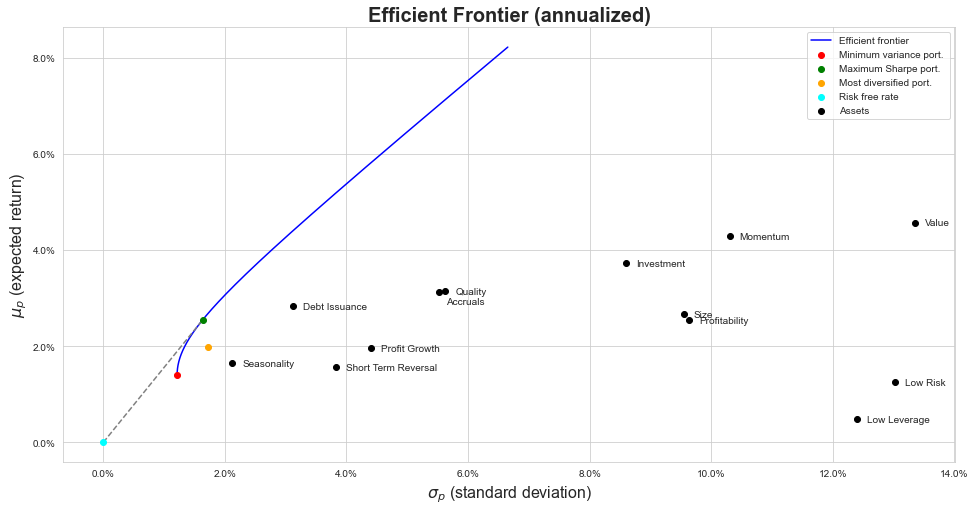

In [812]:
"""
Plot the efficient frontier
"""
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Maximum Sharpe port. ", zorder=10)
ax.scatter(std_mdp, mu_mdp, color="orange", label="Most diversified port. ", zorder=10)

ax.scatter(0, rf, color="cyan", label="Risk free rate", zorder=10)
ax.scatter(vols, mu, color="black", label="Assets", zorder=100)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# add labels to the asset scatterplot with rotation
for i, txt in enumerate(monthly_returns.columns):
    if txt == 'Accruals':
        # modify xy and xytext for the Accruals asset label
        ax.annotate(txt, xy=(vols[i]+0.0012, mu[i]-0.0025), xytext=(0, +0.1), textcoords='offset points')
    else:
        ax.annotate(txt, xy=(vols[i], mu[i]), xytext=(10, -3), textcoords='offset points')

ax.set_title("Efficient Frontier (annualized)", fontweight="bold", fontsize=20)
ax.set_xlabel("$\sigma_p$ (standard deviation)", fontsize=16)
ax.set_ylabel("$\mu_p$ (expected return)", fontsize=16)

ax.legend();

# Evaluating Strategies Out-Of-Sample

In [813]:
"""
Combine Portfolios into one Dataframe
"""

df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# Combine portfolios
df_port_ret['Minimum Variance'] = (returns[window_size:] * df_min_var_port_weights_monthly_epo).sum(axis=1)
df_port_ret['Most Diversified'] = (returns[window_size:] * df_most_div_port_weights_monthly_epo).sum(axis=1)
df_port_ret['Mean-Variance'] = (returns[window_size:] * df_mean_var_port_weights_monthly).sum(axis=1)
df_port_ret['Equally Weighted'] = (returns[window_size:] * w_eq).sum(axis=1)

# Calculate cumulative return
df_port_tri = (1 + df_port_ret).cumprod(axis=0) # probably not the correct way
df_port_cum = df_port_ret.cumsum(axis=0) # Only okay for plotting cumulative returns
df_port_cum

,Minimum Variance,Most Diversified,Mean-Variance,Equally Weighted
date,,,,
1964-12-31,0.000200,0.000360,0.000222,0.000499
1965-01-04,0.000812,0.000877,0.000740,0.000628
1965-01-05,0.001295,0.001422,0.001322,0.001324
1965-01-06,0.001670,0.001951,0.001805,0.001965
1965-01-07,0.001836,0.002134,0.001911,0.002205
...,...,...,...,...
2022-12-23,1.186501,1.240272,1.282712,1.589937
2022-12-27,1.186580,1.240224,1.282688,1.592201
2022-12-28,1.185799,1.239816,1.281999,1.590766


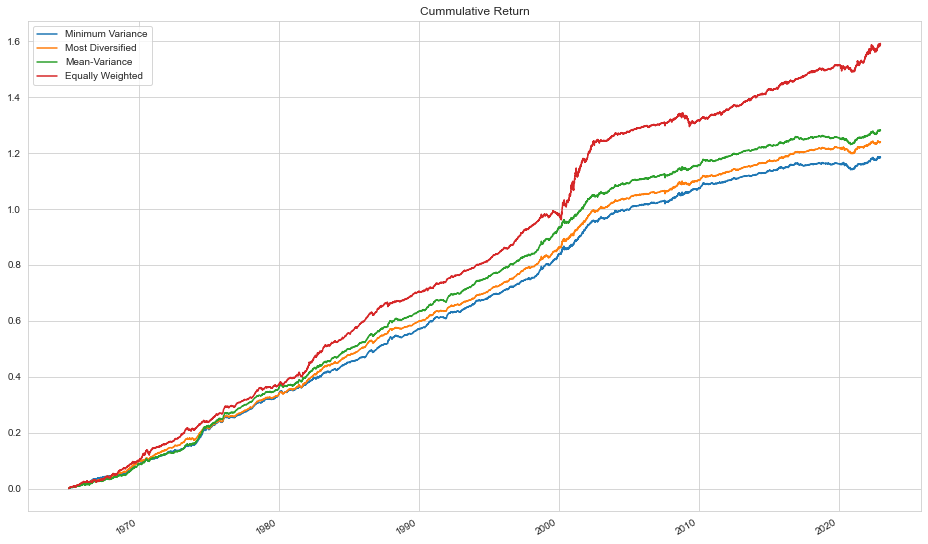

In [814]:
"""
Plot Cumulative Returns
"""

df_port_cum.plot(xlabel="", figsize=(16, 10), title="Cummulative Return", grid='True');

In [815]:
"""
Perfromance Evaluation
"""

# Transform daily returns to monthly
df_port_ret_monthly = (1 + df_port_ret).resample('M').prod() - 1

# Compute Mean
mean_return = df_port_ret_monthly.mean(axis=0)
mean_return.name = "Mean Return"

# Compute Standard Deviation
std_return = df_port_ret_monthly.std(axis=0)
std_return.name = "Standard Deviation"

# Compute Sharpe Ratio
sharpe_ratio = (mean_return / std_return)
sharpe_ratio.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_df = pd.concat([mean_return, std_return, sharpe_ratio], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(df_port_ret_monthly.round(4))
print("\nPerformance Metrics using factor themes:")
print(result_df.round(4))

Monthly Portfolio Returns:
            Minimum Variance  Most Diversified  Mean-Variance  \
date                                                            
1964-12-31            0.0002            0.0004         0.0002   
1965-01-31            0.0019            0.0029         0.0019   
1965-02-28            0.0011            0.0012         0.0014   
1965-03-31            0.0011            0.0009         0.0010   
1965-04-30           -0.0001            0.0014         0.0006   
...                      ...               ...            ...   
2022-08-31            0.0012           -0.0004         0.0008   
2022-09-30            0.0022            0.0006         0.0026   
2022-10-31            0.0056            0.0059         0.0073   
2022-11-30           -0.0005           -0.0017         0.0003   
2022-12-31            0.0015            0.0003         0.0020   

            Equally Weighted  
date                          
1964-12-31            0.0005  
1965-01-31            0.0035  
196

# Test For Stationarity

In [816]:
"""
Perform Dickey Fuller Test on Equally Weighted
"""

eq_ret = df_port_ret['Equally Weighted']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(eq_ret)

ADF Statistic: -19.36134966841025
p-value: 0.0
Critical Values:
	1%: -3.4307992069546227
	5%: -2.861738529600658
	10%: -2.5668756725910593
Null hypothesis rejected. Data is stationary.


In [817]:
"""
Perform Dickey Fuller Test on MDP
"""

mdp_ret = df_port_ret['Most Diversified']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(mdp_ret)

ADF Statistic: -23.892402565530936
p-value: 0.0
Critical Values:
	1%: -3.430798590649988
	5%: -2.8617382572418495
	10%: -2.566875527617365
Null hypothesis rejected. Data is stationary.


In [818]:
"""
Perform Dickey Fuller Test on Minimum Variance
"""

mv_ret = df_port_ret['Minimum Variance']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(mv_ret)

ADF Statistic: -17.636550045009514
p-value: 3.776439569898047e-30
Critical Values:
	1%: -3.4307990835582576
	5%: -2.8617384750690475
	10%: -2.566875643564463
Null hypothesis rejected. Data is stationary.


In [819]:
"""
Perform Dickey Fuller Test on Mean-Variance
"""

mv_ret = df_port_ret['Mean-Variance']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(mv_ret)

ADF Statistic: -18.445772843185487
p-value: 2.1576004728090225e-30
Critical Values:
	1%: -3.430798960229667
	5%: -2.861738420567386
	10%: -2.5668756145538083
Null hypothesis rejected. Data is stationary.


In [820]:
"""
KPSS Test for Stationarity
"""

# assuming your portfolio returns are stored in a variable called 'returns'
lags = 20 # set the number of lags to use in the KPSS test
kpss_test = kpss(eq_ret, regression='c', nlags=lags)

print('KPSS statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('lags:', kpss_test[2])
print('Critical values:')
for key, value in kpss_test[3].items():
    print(f'   {key}: {value:.3f}')

if kpss_test[1] < 0.05:
    print('The portfolio returns are not stationary.')
else:
    print('The portfolio returns are stationary.')

KPSS statistic: 0.3270632222281293
p-value: 0.1
lags: 20
Critical values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The portfolio returns are stationary.


/Users/christoffer/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# CAPM Regressions

In [821]:
"""
Load Fama-French Three-Factor Model
"""

# Resample portfolio returns to run a regression model on monthly returns
df_port_ret_monthly = df_port_ret.resample('M').apply(lambda x: (x + 1).prod() - 1)

# Load the Fama-French three-factor data
df_capm = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/mkt_ret_monthly.xlsx').set_index('date')

# Merge the portfolio returns and Fama-French data
df_rets_capm = pd.merge(df_port_ret_monthly, df_capm, on='date')


In [822]:
"""
Perform Regression on Equally Weighted Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_capm['Equally Weighted']
X = df_rets_capm[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Equally Weighted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.002779
Date:                Mon, 10 Apr 2023   Prob (F-statistic):              0.958
Time:                        13:33:29   Log-Likelihood:                 2744.0
No. Observations:                 697   AIC:                            -5484.
Df Residuals:                     695   BIC:                            -5475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000     12.655      0.0

In [823]:
"""
Perform Regression on Mean-Variance Portfolio Against Fama-French CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_capm['Mean-Variance']
X = df_rets_capm[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Mean-Variance   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.166
Date:                Mon, 10 Apr 2023   Prob (F-statistic):            0.00440
Time:                        13:33:30   Log-Likelihood:                 3095.5
No. Observations:                 697   AIC:                            -6187.
Df Residuals:                     695   BIC:                            -6178.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000     17.253      0.0

In [824]:
"""
Perform Regression on Most Diversified Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_capm['Most Diversified']
X = df_rets_capm[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Most Diversified   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8430
Date:                Mon, 10 Apr 2023   Prob (F-statistic):              0.359
Time:                        13:33:30   Log-Likelihood:                 3160.0
No. Observations:                 697   AIC:                            -6316.
Df Residuals:                     695   BIC:                            -6307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018   9.93e-05     18.057      0.0

In [825]:
"""
Perform Regression on Minimum Variance Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_capm['Minimum Variance']
X = df_rets_capm[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Minimum Variance   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.84
Date:                Mon, 10 Apr 2023   Prob (F-statistic):            0.00104
Time:                        13:33:31   Log-Likelihood:                 3120.2
No. Observations:                 697   AIC:                            -6236.
Df Residuals:                     695   BIC:                            -6227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000     16.596      0.0

# Plotting Average Portfolio Weights and Alphas

In [826]:
# Calculate cumulative return
df_port_tri = (1 + df_port_ret).cumprod(axis=0) # probably not the correct way
df_port_cum = df_port_ret.cumsum(axis=0) # Only okay for plotting cumulative returns

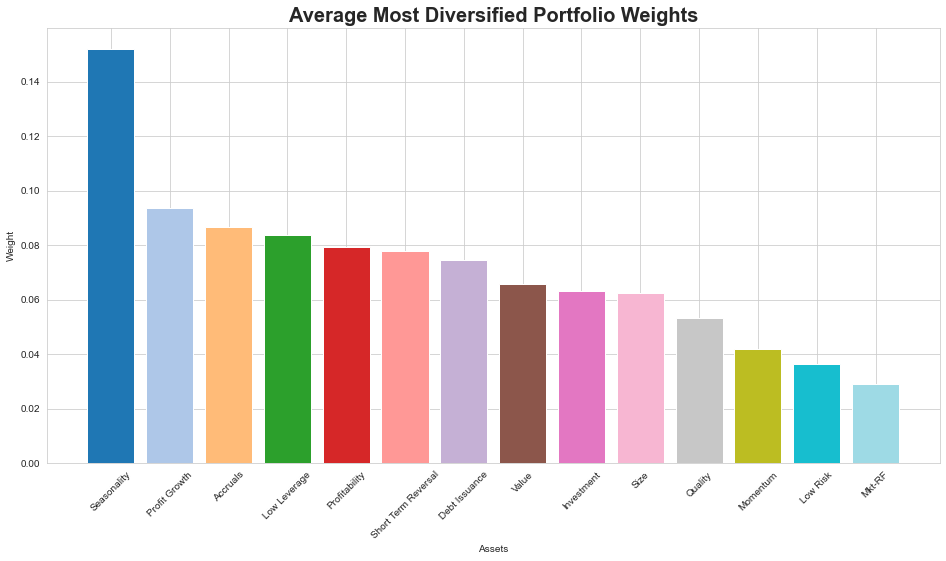

In [827]:
"""
Plot The Average Holdings in Most Diversified Portfolio
"""

# Calculate average weights
average_weights = df_most_div_port_weights_monthly_epo.mean()

# Sort the weights in descending order
sorted_weights = average_weights.sort_values(ascending=False)

# Define a color map for the bars
cmap = plt.get_cmap('tab20')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Create a bar chart to visualize the average weights
plt.figure(figsize=(16,8))
plt.bar(sorted_weights.index, sorted_weights.values, color=ind_colors)
plt.title('Average Most Diversified Portfolio Weights', fontweight = "bold", fontsize=20)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)

plt.show()

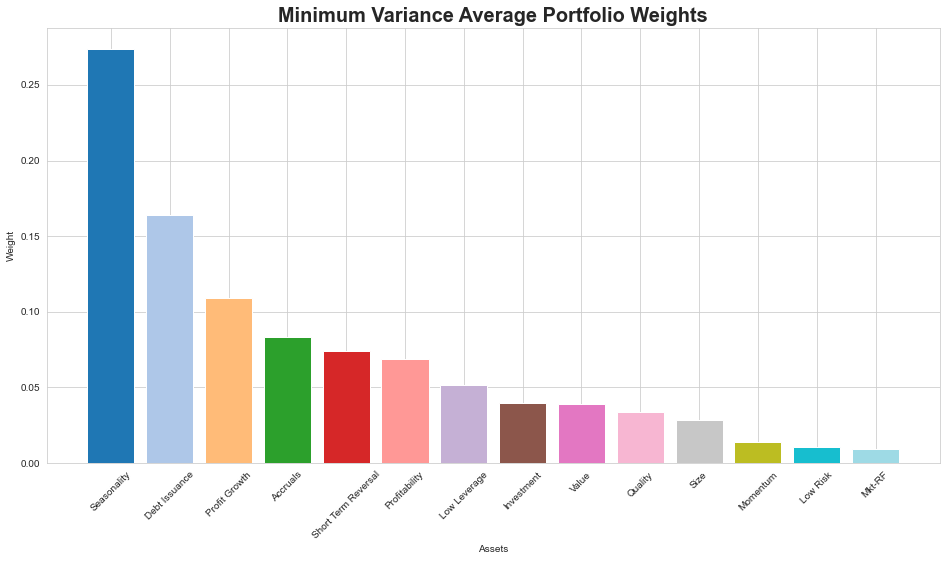

In [828]:
"""
Plot The Average Holdings in Minimum Variance Portfolio
"""

# Calculate average weights
average_weights_min_var = df_min_var_port_weights_monthly_epo.mean()

# Sort the weights in descending order
sorted_weights_min_var = average_weights_min_var.sort_values(ascending=False)

# Define a color map for the bars
cmap = plt.get_cmap('tab20')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Create a bar chart to visualize the average weights
plt.figure(figsize=(16,8))
plt.bar(sorted_weights_min_var.index, sorted_weights_min_var.values, color=ind_colors)
plt.title('Minimum Variance Average Portfolio Weights', fontweight = "bold", fontsize=20)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)

plt.show()

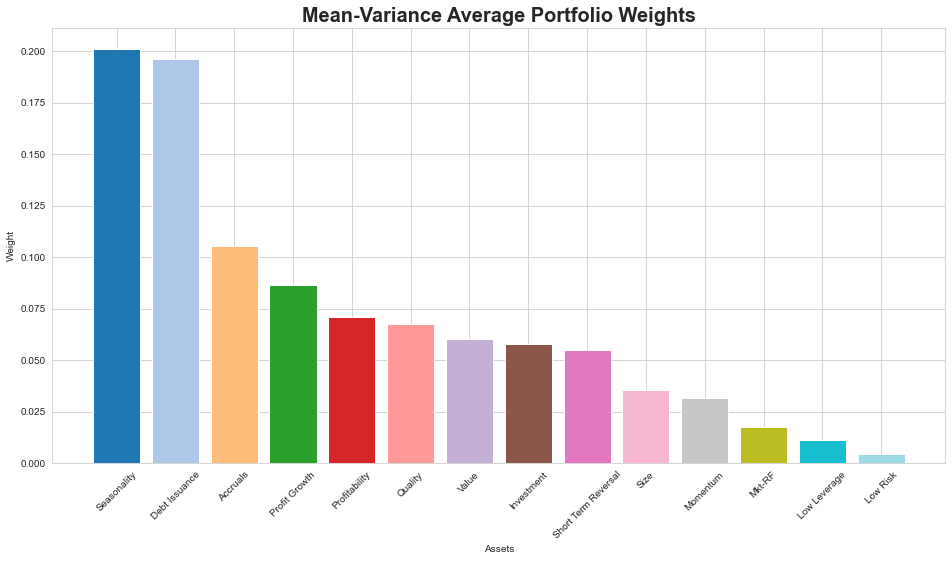

In [829]:
"""
Plot The Average Holdings in Mean-Variance Portfolio
"""

# Calculate average weights
average_weights_mean_var = df_mean_var_port_weights_monthly.mean()

# Sort the weights in descending order
sorted_weights_mean_var = average_weights_mean_var.sort_values(ascending=False)

# Define a color map for the bars
cmap = plt.get_cmap('tab20')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Create a bar chart to visualize the average weights
plt.figure(figsize=(16,8))
plt.bar(sorted_weights_mean_var.index, sorted_weights_mean_var.values, color=ind_colors)
plt.title('Mean-Variance Average Portfolio Weights', fontweight = "bold", fontsize=20)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)

plt.show()

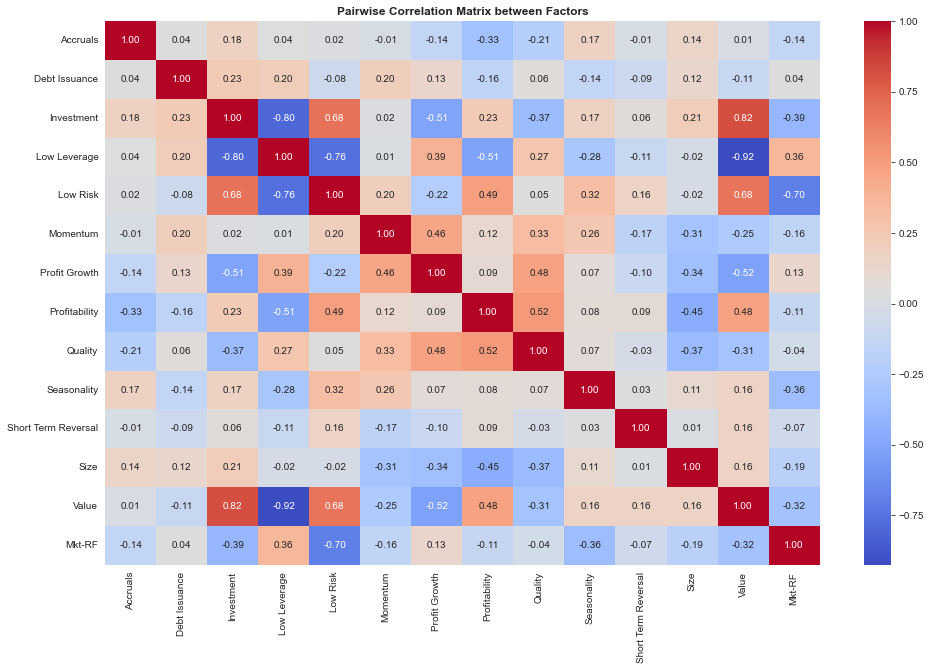

In [830]:

# Compute the correlation matrix between the factors
corr = returns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Pairwise Correlation Matrix between Factors', fontweight='bold')
plt.show()

In [831]:
"""
Perform Regression on Minimum Variance Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = yearly_returns['Low Leverage']
X = yearly_returns[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.params[0] *252)


NameError: name 'yearly_returns' is not defined

In [832]:


# Calculate cumulative return
tot = (1 + returns).cumprod(axis=0) # probably not the correct way
tots = returns.cumsum(axis=0) # Only okay for plotting cumulative returns
tots

,Accruals,Debt Issuance,Investment,Low Leverage,Low Risk,Momentum,Profit Growth,Profitability,Quality,Seasonality,Short Term Reversal,Size,Value,Mkt-RF
date,,,,,,,,,,,,,,
1964-01-02,0.002218,0.001700,0.002860,0.002490,-0.007273,0.000212,-0.000124,-0.003932,-0.001653,0.001605,0.000123,0.006472,0.003631,0.0060
1964-01-03,0.004259,0.002934,0.005519,0.003925,-0.007901,-0.000887,0.000114,-0.004171,-0.001261,0.001428,0.001834,0.005500,0.004214,0.0077
1964-01-06,0.006672,0.003608,0.007035,0.005057,-0.007765,-0.000436,0.001379,-0.003498,-0.001229,0.001394,0.000737,0.005086,0.004274,0.0100
1964-01-07,0.007922,0.004196,0.010478,0.002449,-0.005277,-0.001147,0.002131,-0.005193,-0.004453,0.001327,0.000763,0.005637,0.007614,0.0104
1964-01-08,0.008794,0.004489,0.010726,0.003440,-0.006494,-0.000191,0.002115,-0.005005,-0.003978,0.001744,0.002053,0.007049,0.007629,0.0138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.757675,1.633724,2.086467,0.095344,0.644108,2.445914,1.131012,1.352467,1.822205,0.960172,0.910086,1.414023,2.409873,3.9054
2022-12-27,1.755541,1.633415,2.093673,0.083183,0.656869,2.454177,1.135102,1.365497,1.826408,0.961411,0.909207,1.402967,2.422414,3.9003
2022-12-28,1.757655,1.632915,2.094540,0.086318,0.659381,2.453527,1.130976,1.359677,1.822028,0.959370,0.911097,1.407910,2.416679,3.8880


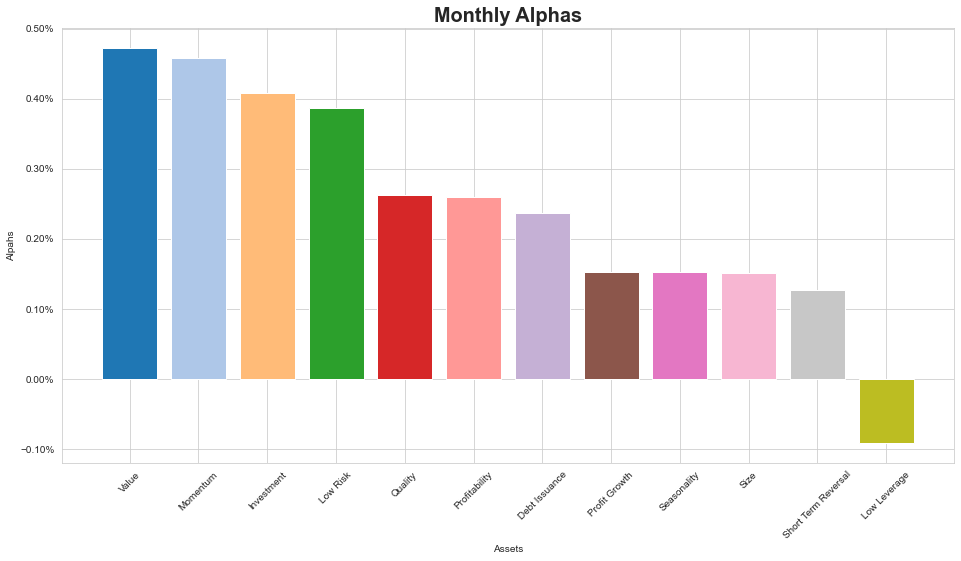

In [833]:
"""
Perform Regression on Factors Against CAPM
"""

import matplotlib.ticker as mtick

# Resample portfolio returns to run a regression model on monthly returns
monthly_returns = returns.resample('M').apply(lambda x: (x + 1).prod() - 1)


# Define the dependent variable
X = monthly_returns[['Mkt-RF']]

# Initialize an empty list to store the alpha coefficients
alphas = []

# Loop over the factor columns in the DataFrame and compute the OLS regression for each one
for col in monthly_returns.columns[1:-1]:
    # Define the independent variable
    y = monthly_returns[[col]]

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Append the alpha (intercept or constant) coefficient to the list
    alphas.append(model.params[0])

# Convert the list of alpha coefficients to a Pandas Series object
alphas = pd.Series(alphas, index=monthly_returns.columns[1:-1])

# Sort the alphas in descending order
sorted_alphas = alphas.sort_values(ascending=False)

# Create a bar chart to visualize the average weights
plt.figure(figsize=(16,8))
plt.bar(sorted_alphas.index, sorted_alphas.values*100, color=ind_colors)
plt.title('Monthly Alphas', fontweight = "bold", fontsize=20)
plt.xlabel('Assets')
plt.ylabel('Alpahs')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

# Test for Stationarity in Diversification Ratio

In [834]:
"""
Perform Dickey Fuller Test on Diversification Ratio
"""

diversification_ratio = most_div_port_cc_monthly_epo

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(diversification_ratio)

ADF Statistic: -3.663739913073121
p-value: 0.004653077786809133
Critical Values:
	1%: -3.4307992686782383
	5%: -2.8617385568777016
	10%: -2.5668756871103398
Null hypothesis rejected. Data is stationary.


# Tming Diversification

In this code below, we first define the historical window for diversification ratios as historical_window. We then calculate the historical rolling window of diversification ratios using pd.Series(most_div_port_cc_monthly_epo).rolling(historical_window).mean(), which computes the rolling mean of the diversification ratios over a historical window of 12 months.

We then compute the historical average and standard deviation of the rolling window using .mean() and .std(), respectively.

Next, we calculate the z-score of the current diversification ratio relative to historical levels using (diversification_ratio - historical_mean) / historical_std. We then adjust the leverage factor based on the z-score using np.clip(1 + z_score * 0.1, min_leverage_factor, max_leverage_factor), where we upscale or descale the leverage factor by 0.1 times the z-score, while also ensuring that the leverage factor stays within the range of min_leverage_factor and max_leverage_factor.

Finally, we upscale or descale the portfolio weights based on the adjusted leverage factor using original_weights * leverage_factor.

You can adjust the historical window, maximum and minimum leverage factors, and the multiplier for the z-score as needed for your specific portfolio and diversification goals.

In [913]:
"""
Define inputs to timing diversification strategy
"""

# Define the historical window for diversification ratios
historical_window = 252 # 252 trading days

# Define the original portfolio weights and diversification ratio
original_weights = most_div_port_weights_monthly_epo

# Define the maximum and minimum leverage factors
max_leverage_factor = 1.5
min_leverage_factor = 0.5


In [914]:
"""
Calculate z-score
"""

# Calculate the historical average and standard deviation of the rolling window
historical_mean = pd.Series(most_div_port_cc_monthly_epo).rolling(historical_window).mean()
historical_std = pd.Series(most_div_port_cc_monthly_epo).rolling(historical_window).std()

# Calculate the z-score of the current diversification ratio relative to historical levels
z_score = (diversification_ratio - historical_mean) / historical_std
z_score = z_score.fillna(1)


In [915]:
"""
Calculate new MDP portfolio weights scaled to z-score
"""

# Calculate the adjusted leverage factor based on the z-score
leverage_factor = np.clip(1 + z_score * 0.5, min_leverage_factor, max_leverage_factor)

# Reshape the leverage factor to have the same shape as the original weights
leverage_factor = leverage_factor.to_numpy().reshape(-1, 1)

# Upscale or descale the portfolio weights based on the adjusted leverage factor
new_weights = original_weights * leverage_factor


We multiply the z_score with 0.1 to control the sensitivity of the leverage factor to changes in the diversification ratio.

The z_score represents the number of standard deviations by which the current diversification ratio deviates from the historical mean. If the z_score is positive, it means that the current diversification ratio is higher than the historical average, and vice versa.

Multiplying the z_score with a constant like 0.1 scales the impact of the z_score on the leverage factor. A larger constant like 1 would amplify the effect of the z_score, while a smaller constant like 0.01 would dampen the effect of the z_score.

In this code, we chose a value of 0.1 based on the assumption that the diversification ratio is a relatively stable metric that doesn't fluctuate wildly over time. By using a small multiplier like 0.1, we can ensure that the adjusted leverage factor is sensitive to changes in the diversification ratio, but not overly reactive to short-term fluctuations.

Of course, the appropriate value for the multiplier may vary depending on the specific portfolio and diversification goals. In practice, it may be helpful to experiment with different values for the multiplier to find the value that works best for the given portfolio.

In [916]:
"""
Performance Evalutaion of Dynamic Strategy
"""

dyn_port = pd.DataFrame(index=returns.index[window_size:])

# Combine portfolios
dyn_port['min-var'] = (returns[window_size:] * df_min_var_port_weights_monthly_epo).sum(axis=1)
dyn_port['most-div'] = (returns[window_size:] * new_weights).sum(axis=1)
dyn_port['mean-var'] = (returns[window_size:] * df_mean_var_port_weights_monthly).sum(axis=1)
dyn_port['eq-weight'] = (returns[window_size:] * w_eq).sum(axis=1)

# Calculate cumulative return
dyn_port_tri = (1 + dyn_port).cumprod(axis=0) # probably not the correct way
dyn_port_cum = dyn_port.cumsum(axis=0) # Only okay for plotting cumulative returns
dyn_port_cum

,min-var,most-div,mean-var,eq-weight
date,,,,
1964-12-31,0.000200,0.000541,0.000222,0.000499
1965-01-04,0.000812,0.001315,0.000740,0.000628
1965-01-05,0.001295,0.002133,0.001322,0.001324
1965-01-06,0.001670,0.002927,0.001805,0.001965
1965-01-07,0.001836,0.003200,0.001911,0.002205
...,...,...,...,...
2022-12-23,1.186501,1.269846,1.282712,1.589937
2022-12-27,1.186580,1.269822,1.282688,1.592201
2022-12-28,1.185799,1.269618,1.281999,1.590766


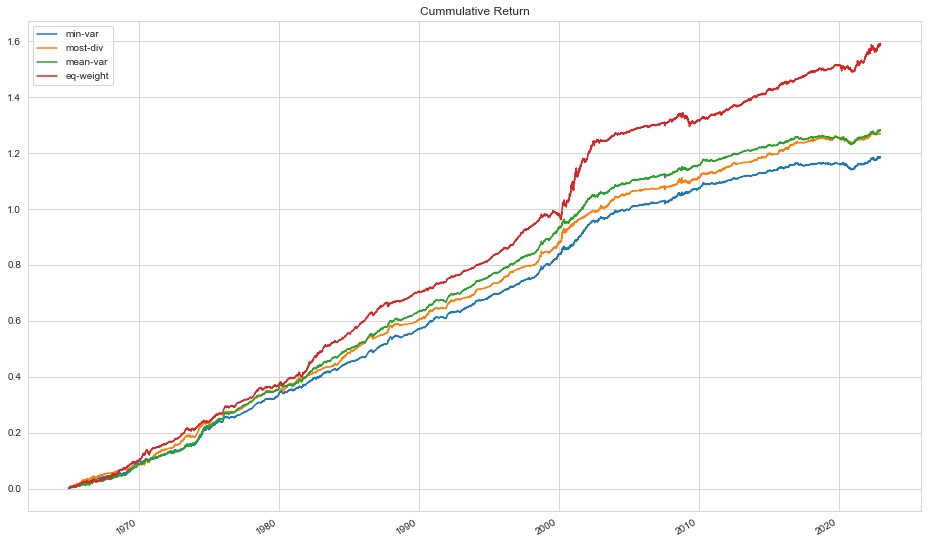

In [917]:
"""
Plot Cumulative Returns
"""

dyn_port_cum.plot(xlabel="", figsize=(16, 10), title="Cummulative Return", grid='True');

In [918]:
"""
Perfromance Evaluation
"""

# Transform daily returns to monthly
dyn_port_y = (1 + dyn_port).resample('M').prod() - 1

# Compute Mean
dyn_mean_return = dyn_port_y.mean(axis=0)
dyn_mean_return.name = "Mean Return"

# Compute Standard Deviation
dyn_std_return = dyn_port_y.std(axis=0)
dyn_std_return.name = "Standard Deviation"

# Compute Sharpe Ratio
dyn_sharpe_ratio = (dyn_mean_return / dyn_std_return)
dyn_sharpe_ratio.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_dyn = pd.concat([dyn_mean_return, dyn_std_return, dyn_sharpe_ratio], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(dyn_port_y.round(4))
print("\nPerformance Metrics:")
print(result_dyn.round(4))

Monthly Portfolio Returns:
            min-var  most-div  mean-var  eq-weight
date                                              
1964-12-31   0.0002    0.0005    0.0002     0.0005
1965-01-31   0.0019    0.0043    0.0019     0.0035
1965-02-28   0.0011    0.0018    0.0014     0.0014
1965-03-31   0.0011    0.0014    0.0010     0.0007
1965-04-30  -0.0001    0.0021    0.0006     0.0019
...             ...       ...       ...        ...
2022-08-31   0.0012   -0.0002    0.0008    -0.0051
2022-09-30   0.0022    0.0003    0.0026    -0.0006
2022-10-31   0.0056    0.0029    0.0073     0.0138
2022-11-30  -0.0005   -0.0009    0.0003     0.0047
2022-12-31   0.0015    0.0002    0.0020     0.0013

[697 rows x 4 columns]

Performance Metrics:
           Mean Return  Standard Deviation  Sharpe Ratio
min-var         0.0017              0.0028        0.6139
most-div        0.0018              0.0029        0.6211
mean-var        0.0018              0.0029        0.6420
eq-weight       0.0023              

# Deleted

In [202]:
""" 
Perform calculations for MDP with daily rebalancing
"""

most_div_port_weights_daily = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_daily = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # most diversified
    most_div_port_weights_daily[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc_daily[t] = calculate_cc_ratio(most_div_port_weights_daily[t, :], cov_mat)

# store in data-frame
df_most_div_port_weights_daily = pd.DataFrame(data=most_div_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

KeyboardInterrupt: 

In [ ]:
""" 
Perform calculations for min_var with daily rebalancing 
"""

min_var_port_weights_daily = np.zeros((eff_num_periods, num_assets))
min_var_port_cc_daily = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_simple_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # mnimum variance
    min_var_port_weights_daily[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc_daily[t] = calculate_cc_ratio(min_var_port_weights_daily[t, :], cov_mat)
    
# store in data-frame
df_min_var_port_weights_daily = pd.DataFrame(data=min_var_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [ ]:
""" 
Plot Minimum Variance Weights with daily rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_daily.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=12)
ax.set_title("Minimum variance portfolios with Daily Rebalancing", fontsize=16, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

In [ ]:
"""
Define Function for Tangency Portfolio - Mean-Variance Portfolio
"""

def tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    mu: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)
    
    return w_max_sr

In [ ]:
"""
Test for Normality in Equally Weighted
"""

# Define the function to test for normality
def test_normality(x):
    jb = jarque_bera(x)
    norm = normaltest(x)
    print(f"Jarque-Bera test statistic: {jb[0]} with p-value: {jb[1]}")
    print(f"Normality test statistic: {norm[0]} with p-value: {norm[1]}")
    if jb[1] < 0.05 or norm[1] < 0.05:
        print("The portfolio returns are not normally distributed.")
    else:
        print("The portfolio returns are normally distributed.")

# Apply the normality test to your portfolio returns
test_normality(eq-ret)

In [ ]:
cc_ratios_lw = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = ledoit_wolf_constant_variance(returns.iloc[t: window_size + t, :].values)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios_lw[t] = calculate_cc_ratio(w_eq, cov_mat)